# 5.3 사전 훈련된 컨브넷 사용하기

### 사전 훈련된 네트워크(pretrained network)
- pretrained network는 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련된 네트워크를 뜻함
- pretrained network를 사용하는 것은 작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 효과적인 방법


- **일반적이고 충분히 큰 데이터셋에 훈련된 네트워크의 특성 계층 구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있음**
- 위와 같은 유연성은 얕은 학습과 비교해서 딥러닝의 핵심 장점이라고 할 수 있음
- 이런 특성은 완전히 다른 클래스의 경우라도 많은 컴퓨터 비전 문제에서 유용함


- 여기서는 ImageNet 데이터셋으로 학습된 VGG16 모델을 사용
    - ImageNet Dataset은 1400만개의 이미지와 1000개의 class를 가짐
    - VGG16 말고도 다른 많은 모델들에도 적용이 가능하지만 간단해서 사용
    

## Pretrained network 사용 방법 2가지
1. **특성 추출(Feature Extraction)**
2. **미세 조정(Fine Tuning)**

## 5.3.1 특성 추출 (Feature Extraction)

### 특성 추출
- 특성 추출은 사전에 학습된 네트워크의 표현을 사용해 새로운 샘플의 특성을 뽑아내는 것


### Convnet의 특성 추출
- Convnet의 구성
    - 합성곱 기반 층
        - Convolutional layer
        - Pooling layer
    - 완전 연결 분류기
        - Fully connected layer


- 1번째 합성곱 기반 층은 동결시킨 후 재사용
- 2번째 완전 연결 분류기는 새로 학습시킴
- 따라서 **동결된 합성곱 기반 층의 출력을 이용해 2번째 완전 연결 분류기를 새로 학습시키는 방식**


### 합성곱 층만 재사용 하는 이유
- **합성곱 층에 의해 학습된 표현이 더 일반적이므로** 여러 컴퓨터비전 문제에서 유용하게 사용 가능함
- convnet의 feature map은 사진에 대해 일반적인 컨셉의 존재 여부를 기록한 맵임
- **완전 연결 층은 어떤 클래스가 존재할 확률에 관한 정보만 담고있으므로 클래스가 겹치지 않는 경우에는 재사용 하지 않음**
- 참고) ImageNet에는 고양이와 강아지가 있어서 완전 연결 층도 재사용하는 것이 더 도움이 되지만 새로운 문제의 클래스가 원본 모델의 클래스와 겹치지 않는 일반적인 경우를 다루기 위해 사용하지 않았음


### 합성곱 층의 추출 정도
- **합성곱 층에서 추출한 표현의 일반성(재사용성)은 모델 층의 깊이에 달려있음**
- 모델의 **하위 층은 지역적(엣지, 색깔, 질감 등)이고 일반적인 특성맵**으로 구성됨
- 모델의 **상위 층은 고수준(강아지 눈이나 고양이 귀 등)의 추상적인 특성맵**으로 구성됨
- **사용할 데이터 셋이 원본 모델에 사용된 데이터 셋과 많이 다르다면 전체 합성곱 층을 재사용 하는 것 보다는 하위 층 일부만 추출해 사용하는 것이 좋음**

### VGG 모델 가져오기

케라스의 `keras.applications`모듈을 이용해 구현

- `keras.applications` 모듈
    - 여러 이미지 분류 모델을 import해서 사용할 수 있음(이 절에서 VGG16 모델을 가져올 때 사용)
    - 사용 가능한 여러 모델이 있음(모두 ImageNet에서 훈련된 모델)
        - Xception
        - Inception V3
        - ResNet50
        - VGG16
        - VGG19
        - MobileNet
        
- `VGG16()`의 매개변수들

    - `weights`
        - 초기화할 가중치 체크포인트
        - None 지정 시 random initialization
        - 'imagenet' 지정 시 imagenet에 pretrained된 가중치

    - `include_top`
        - 최상위 완전 연결 분류기의 포함 여부

    - `input_shape`
        - 네트워크에 주입할 이미지 텐서 크기
        - 이 값을 지정하지 않으면 어떤 크기의 입력도 처리할 수 있음
        - include_top이 True였다면 완전 연결 분류기가 추가되므로 원본 모델과 동일한 (224, 224, 3)이 되어야 함

In [1]:
# VGG16 합성곱 층 가져오기

from keras.applications import VGG16

vgg16_conv = VGG16(weights='imagenet', 
                   include_top=False, 
                   input_shape=(150, 150, 3))

vgg16_conv.summary()

Using TensorFlow backend.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### 완전 연결 층 추가 방법 2가지

- Data Augmentation을 사용하지 않는 빠른 특성 추출
    - 합성곱 기반 층에서의 출력을 numpy array로 저장
    - 저장한 결과를 입력으로 완전 연결 층만 학습
    - 합성곱 기반 층을 1번만 실행하므로 빠르지만 그로 인해 Data Augmentation 사용 불가능


- Data Augmentation을 사용한 특성 추출
    - 불러온 convnet 위에 바로 완전 연결 층을 쌓아 확장
    - 바로 입력부터 출력까지 end-to-end로 전체 모델 실행하며 학습
    - 합성곱 기반 층을 매번 실행하므로 느리지만 그로 인해 Data Augmentation 사용 가능

### 1. Data Augmentation을 사용하지 않는 빠른 특성 추출

In [2]:
# pretrained vgg16 network의 feature extraction

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = "./datasets/cats_and_dogs/small"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, samples):
    features = np.zeros((samples, 4, 4, 512))
    labels = np.zeros((samples,))
    

    generator = datagen.flow_from_directory(directory, 
                                            target_size=(150, 150), 
                                            batch_size=batch_size, 
                                            class_mode='binary')
    
    i = 0
    
    for input_batch, input_labels in generator:
        features[i*batch_size : (i+1)*batch_size] = vgg16_conv.predict(input_batch)
        labels[i*batch_size : (i+1)*batch_size] = input_labels
        i += 1
        
        if (i*batch_size) >= samples:
            break
            
    return features, labels


train_features, train_labels = extract_features(train_dir, 2000)
val_features, val_labels = extract_features(val_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

print(train_features.shape, train_labels.shape)
print(val_features.shape, val_labels.shape)
print(test_features.shape, test_labels.shape)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
(2000, 4, 4, 512) (2000,)
(1000, 4, 4, 512) (1000,)
(1000, 4, 4, 512) (1000,)


In [3]:
train_features = np.reshape(train_features, (2000, 4*4*512))
val_features = np.reshape(val_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

print(train_features.shape, train_labels.shape)
print(val_features.shape, val_labels.shape)
print(test_features.shape, test_labels.shape)

(2000, 8192) (2000,)
(1000, 8192) (1000,)
(1000, 8192) (1000,)


In [4]:
# 완전 연결 층 만들고 훈련
# Dropout regularization 사용

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(val_features, val_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 306us/step - loss: 0.5807 - acc: 0.6770 - val_loss: 0.4467 - val_acc: 0.8220
Epoch 2/30
2000/2000 [==============================] - 0s 208us/step - loss: 0.4190 - acc: 0.8055 - val_loss: 0.3663 - val_acc: 0.8480
Epoch 3/30
2000/2000 [==============================] - 0s 212us/step - loss: 0.3433 - acc: 0.8565 - val_loss: 0.3312 - val_acc: 0.8650
Epoch 4/30
2000/2000 [==============================] - 0s 209us/step - loss: 0.3129 - acc: 0.8745 - val_loss: 0.3049 - val_acc: 0.8790
Epoch 5/30
2000/2000 [==============================] - 0s 211us/step - loss: 0.2847 - acc: 0.8835 - val_loss: 0.2890 - val_acc: 0.8880
Epoch 6/30
2000/2000 [==============================] - 0s 208us/step - loss: 0.2579 - acc: 0.8970 - val_loss: 0.2772 - val_acc: 0.8920
Epoch 7/30
2000/2000 [==============================] - 0s 208us/step - loss: 0.2457 - acc: 0.8975 - val_loss: 0.2693 - val_acc: 0.8970


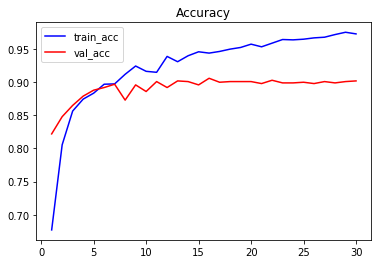

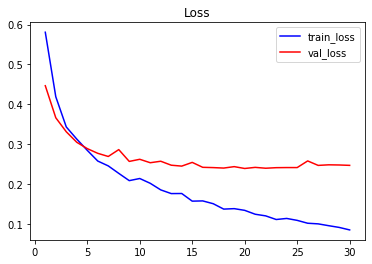

In [6]:
# 결과 그래프 그리기

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='train_acc')
plt.plot(epochs, val_acc, 'r', label='val_acc')
plt.title("Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='train_loss')
plt.plot(epochs, val_loss, 'r', label='val_loss')
plt.title("Loss")
plt.legend()
plt.show()

**결과 분석**
- 약 90%의 검증 정확도
- 처음부터 훈련시킨 모델에 비해 훨씬 성능이 좋음
- **dropout을 높은 비율로 사용했지만 overfitting이 일어남**
- **작은 이미지 데이터셋에서는 필수적인 Data Augmentation을 사용하지 않았기 때문**

### 2. Data Augmentation을 사용한 특성 추출

In [7]:
# pretrained vgg16 모델 위에 완전 연결 층 올리기

from keras import models
from keras import layers

model_aug = models.Sequential()

# add()에 그냥 모델 넣으면 됨
model_aug.add(vgg16_conv)

model_aug.add(layers.Flatten())

model_aug.add(layers.Dense(256, activation='relu'))
# model_aug.add(layers.Dropout(0.5))
model_aug.add(layers.Dense(1, activation='sigmoid'))

model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [8]:
from keras import optimizers

# vgg16 pretrained model 가중치 업데이트 동결시키기
# 각 층마다 업데이트 될 가중치 텐서는 2개씩 있음(가중치 행렬, bias 벡터)

print("vgg16 모델 가중치 업데이트 동결 전 업데이트 될 가중치 텐서 수 : ", len(model_aug.trainable_weights))

vgg16_conv.trainable = False

print("vgg16 모델 가중치 업데이트 동결 후 업데이트 될 가중치 텐서 수 : ", len(model_aug.trainable_weights))

# trainable 속성 변경 후 compile()해줘야 변경 사항이 적용됨
model_aug.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=2e-5),
                  metrics=['acc'])

vgg16 모델 가중치 업데이트 동결 전 업데이트 될 가중치 텐서 수 :  30
vgg16 모델 가중치 업데이트 동결 후 업데이트 될 가중치 텐서 수 :  4


In [9]:
# Augmentation 적용 후 전체 모델 학습

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(150, 150),
                                                batch_size=20,
                                                class_mode='binary')

history_aug = model_aug.fit_generator(train_generator,
                                      steps_per_epoch=100,
                                      epochs=30,
                                      validation_data=val_generator,
                                      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 15s 149ms/step - loss: 0.5724 - acc: 0.7140 - val_loss: 0.5040 - val_acc: 0.8210
Epoch 2/30
100/100 [==============================] - 14s 144ms/step - loss: 0.4743 - acc: 0.7885 - val_loss: 0.3935 - val_acc: 0.8370
Epoch 3/30
100/100 [==============================] - 14s 143ms/step - loss: 0.4235 - acc: 0.8130 - val_loss: 0.2694 - val_acc: 0.8690
Epoch 4/30
100/100 [==============================] - 14s 142ms/step - loss: 0.3899 - acc: 0.8255 - val_loss: 0.3486 - val_acc: 0.8780
Epoch 5/30
100/100 [==============================] - 14s 141ms/step - loss: 0.3761 - acc: 0.8330 - val_loss: 0.1801 - val_acc: 0.8710
Epoch 6/30
100/100 [==============================] - 14s 144ms/step - loss: 0.3534 - acc: 0.8525 - val_loss: 0.3750 - val_acc: 0.8860
Epoch 7/30
100/100 [==============================] - 14s 143ms/step - loss: 0.3489 - acc: 0.8465 - val_lo

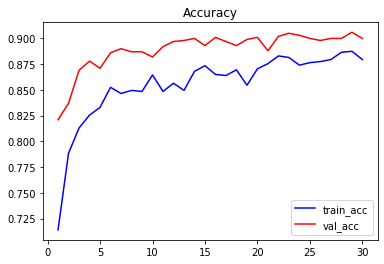

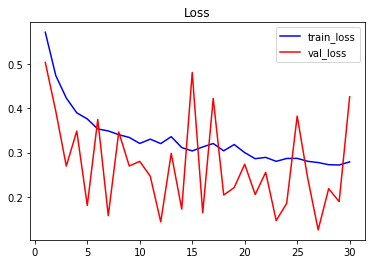

In [10]:
# 결과 그래프 그리기

import matplotlib.pyplot as plt

acc = history_aug.history['acc']
val_acc = history_aug.history['val_acc']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='train_acc')
plt.plot(epochs, val_acc, 'r', label='val_acc')
plt.title("Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='train_loss')
plt.plot(epochs, val_loss, 'r', label='val_loss')
plt.title("Loss")
plt.legend()
plt.show()

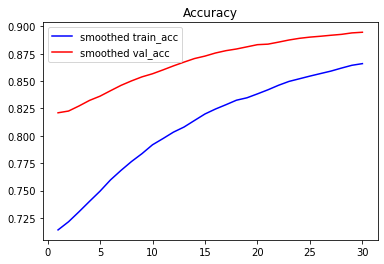

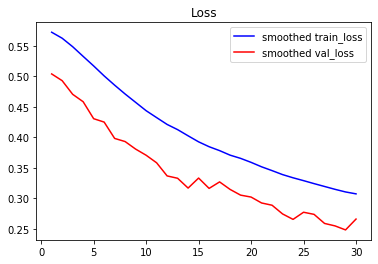

In [12]:
# 그래프의 값 변동이 심하므로 지수이동평균 적용

def smooth_curve(points, factor=0.9):
    smoothed_curve = []
    for point in points:
        if smoothed_curve:
            prev = smoothed_curve[-1]
            smoothed_curve.append(prev*factor + point*(1-factor))
        else:
            smoothed_curve.append(point)
            
    return smoothed_curve


plt.plot(epochs, smooth_curve(acc), 'b', label='smoothed train_acc')
plt.plot(epochs, smooth_curve(val_acc), 'r', label='smoothed val_acc')
plt.title("Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, smooth_curve(loss), 'b', label='smoothed train_loss')
plt.plot(epochs, smooth_curve(val_loss), 'r', label='smoothed val_loss')
plt.title("Loss")
plt.legend()
plt.show()

**결과 분석**
- 처음과 정확도는 비슷하지만 **Overfitting이 줄었음**
- **소규모 데이터셋에서는 항상 Augmentation을 적용하자!**

## 5.3.2 미세 조정 (Fine Tuning)

### 미세 조정
- 미세 조정은

